# Omni Recognition with Qwen3-VL (Together AI)
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/togethercomputer/together-cookbook/blob/main/Multimodal/Vision/Omni_Recognition.ipynb)


## Introduction

In this notebook, we'll explore Qwen3-VL's "recognize anything" capabilities using Together AI's API. The model can recognize:

- Celebrities and public figures
- Anime characters
- Food items (with multilingual names)
- Landmarks and locations
- And much more!

We'll also explore object spotting with bounding boxes.


### Install required libraries


In [ ]:
!pip install together pydantic pillow


In [3]:
import os
import json
import base64
import together
from typing import Optional, List
from pydantic import BaseModel, Field
from PIL import Image, ImageDraw, ImageFont, ImageColor
from IPython.display import display

# Together AI Configuration
client = together.Together()

MODEL_ID = "Qwen/Qwen3-VL-32B-Instruct"

print(f"Using model: {MODEL_ID}")
print(f"API Key configured: {bool(os.environ.get('TOGETHER_API_KEY'))}")


Using model: Qwen/Qwen3-VL-32B-Instruct
API Key configured: True


In [4]:
# Pydantic schemas for structured JSON output
class RecognitionResult(BaseModel):
    """A single object recognition result."""
    bbox_2d: Optional[List[int]] = Field(None, description="Bounding box coordinates [x1, y1, x2, y2] in normalized 0-1000 scale")
    label_en: str = Field(description="Object name in English")
    label_zh: Optional[str] = Field(None, description="Object name in Chinese")

class RecognitionList(BaseModel):
    """List of recognized objects."""
    objects: List[RecognitionResult] = Field(description="List of detected and recognized objects")


# Utility functions
def encode_image(image_path):
    """Encode image to base64."""
    with open(image_path, "rb") as f:
        return base64.b64encode(f.read()).decode("utf-8")

def get_mime_type(image_path):
    """Get MIME type from file extension."""
    ext = image_path.split(".")[-1].lower()
    return "jpeg" if ext in ["jpg", "jpeg"] else ext

def inference_with_api(image_path, prompt, max_tokens=4096):
    """Run inference with Together AI API."""
    base64_image = encode_image(image_path)
    mime_type = get_mime_type(image_path)
    
    response = client.chat.completions.create(
        model=MODEL_ID,
        messages=[{
            "role": "user",
            "content": [
                {"type": "image_url", "image_url": {"url": f"data:image/{mime_type};base64,{base64_image}"}},
                {"type": "text", "text": prompt},
            ],
        }],
        max_tokens=max_tokens,
    )
    return response.choices[0].message.content

def inference_with_json_schema(image_path, prompt, schema: type[BaseModel], max_tokens=4096):
    """Run inference with Together AI API using JSON mode."""
    base64_image = encode_image(image_path)
    mime_type = get_mime_type(image_path)
    
    response = client.chat.completions.create(
        model=MODEL_ID,
        messages=[
            {
                "role": "system",
                "content": f"Analyze the image and respond only in JSON following this schema: {json.dumps(schema.model_json_schema())}",
            },
            {
                "role": "user",
                "content": [
                    {"type": "image_url", "image_url": {"url": f"data:image/{mime_type};base64,{base64_image}"}},
                    {"type": "text", "text": prompt},
                ],
            }
        ],
        max_tokens=max_tokens,
        response_format={
            "type": "json_schema",
            "schema": schema.model_json_schema(),
        },
    )
    
    return json.loads(response.choices[0].message.content)

def plot_recognition_results(im, objects):
    """Plot recognition results on an image."""
    img = im.copy()
    width, height = img.size
    draw = ImageDraw.Draw(img)
    
    colors = ['red', 'green', 'blue', 'yellow', 'orange', 'pink', 'purple', 'cyan']
    
    try:
        font = ImageFont.truetype("/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf", size=14)
    except:
        font = ImageFont.load_default()

    for i, obj in enumerate(objects):
        if obj.get("bbox_2d"):
            bbox = obj["bbox_2d"]
            color = colors[i % len(colors)]
            
            # Convert normalized coordinates (0-1000) to absolute coordinates
            abs_x1 = int(bbox[0] / 1000 * width)
            abs_y1 = int(bbox[1] / 1000 * height)
            abs_x2 = int(bbox[2] / 1000 * width)
            abs_y2 = int(bbox[3] / 1000 * height)

            draw.rectangle(((abs_x1, abs_y1), (abs_x2, abs_y2)), outline=color, width=3)
            
            label = obj["label_en"]
            if obj.get("label_zh"):
                label += f" ({obj['label_zh']})"
            
            draw.text((abs_x1 + 8, abs_y1 + 6), label, fill=color, font=font)

    display(img)

## 1. Object Recognition

Identify objects, people, or characters in images.


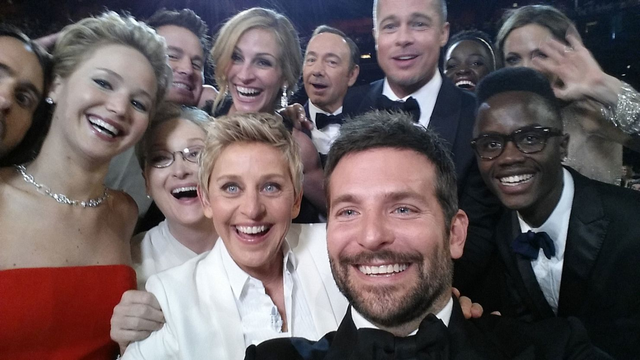

This is the famous "Oscars selfie" taken at the 2014 Academy Awards. The photo was taken by Bradley Cooper and features a group of celebrities posing together. From left to right and front to back, the people in the image are:

**Front row (left to right):**
- **Jennifer Lawrence** – in the red dress, smiling widely.
- **Ellen DeGeneres** – in the white blazer, taking the selfie with Bradley Cooper.
- **Bradley Cooper** – in the foreground, taking the selfie.

**Back row (left to right):**
- **Angelina Jolie** – partially visible on the far left, behind Jennifer Lawrence.
- **Brad Pitt** – smiling, wearing a tuxedo.
- **Channing Tatum** – behind Brad Pitt, smiling.
- **Meryl Streep** – behind Bradley Cooper, wearing glasses and laughing.
- **Lupita Nyong’o** – behind Brad Pitt, smiling broadly.
- **Kevin Spacey** – behind Channing Tatum, wearing a bow tie.
- **Diane Keaton** – behind Meryl Streep, waving.
- **Janelle Monáe** – behind Lupita Nyong’o, partially visible.
- **Alfonso Cuaró

In [5]:
# Example: Celebrity recognition
image_path = "../assets/gettyimages-476996143.jpg"
prompt = "Who are these people? Provide the names."

image = Image.open(image_path)
image.thumbnail([640, 640], Image.Resampling.LANCZOS)
display(image)

response = inference_with_api(image_path, prompt)
print(response)


## 2. Object Spotting

Identify multiple objects and return their bounding boxes and names.

**Note:** Coordinates use relative scale from 0 to 1000.


{
  "objects": [
    {
      "bbox_2d": [
        0,
        309,
        104,
        634
      ],
      "label_en": "assorted breads and pretzels",
      "label_zh": "\u5404\u79cd\u9762\u5305\u548c\u6912\u76d0\u5377\u997c"
    },
    {
      "bbox_2d": [
        96,
        333,
        233,
        468
      ],
      "label_en": "bagels and rolls",
      "label_zh": "\u767e\u5409\u997c\u548c\u9762\u5305\u5377"
    },
    {
      "bbox_2d": [
        154,
        475,
        288,
        660
      ],
      "label_en": "sushi rolls with salmon and cream cheese",
      "label_zh": "\u4e09\u6587\u9c7c\u548c\u5976\u6cb9\u5976\u916a\u5bff\u53f8\u5377"
    },
    {
      "bbox_2d": [
        27,
        655,
        157,
        852
      ],
      "label_en": "watermelon slices",
      "label_zh": "\u897f\u74dc\u7247"
    },
    {
      "bbox_2d": [
        198,
        667,
        327,
        861
      ],
      "label_en": "chocolate cookies",
      "label_zh": "\u5de7\u514b\u529b\u997

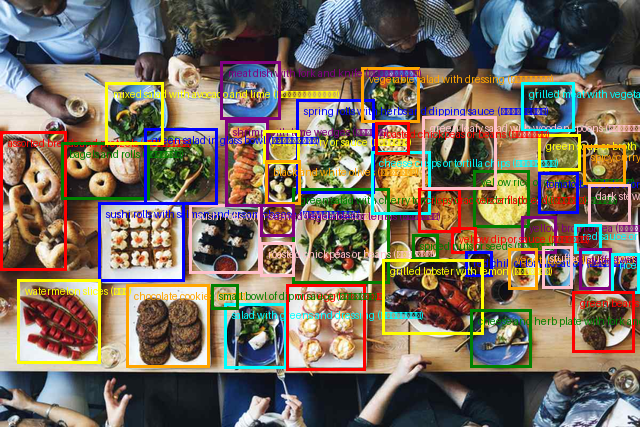

In [6]:
# Example: Food spotting with multilingual names
image_path = "../assets/swedish-smorgasbord-how-to.jpg"
prompt = "Identify all food items in the image and return their bounding box and names in the objects array."

image = Image.open(image_path)
image.thumbnail([640, 640], Image.Resampling.LANCZOS)

result = inference_with_json_schema(image_path, prompt, RecognitionList)
print(json.dumps(result, indent=2))

plot_recognition_results(image, result["objects"])

{
  "objects": [
    {
      "bbox_2d": [
        20,
        312,
        160,
        1000
      ],
      "label_en": "Vegeta",
      "label_zh": "\u8d1d\u5409\u5854"
    },
    {
      "bbox_2d": [
        170,
        522,
        320,
        1000
      ],
      "label_en": "Gohan (child)",
      "label_zh": "\u609f\u996d\uff08\u7ae5\u5e74\uff09"
    },
    {
      "bbox_2d": [
        73,
        12,
        430,
        1000
      ],
      "label_en": "Piccolo",
      "label_zh": "\u6bd4\u514b"
    },
    {
      "bbox_2d": [
        290,
        306,
        440,
        1000
      ],
      "label_en": "Trunks (future)",
      "label_zh": "\u7279\u5170\u514b\u65af\uff08\u672a\u6765\uff09"
    },
    {
      "bbox_2d": [
        380,
        44,
        600,
        1000
      ],
      "label_en": "Goku",
      "label_zh": "\u5b59\u609f\u7a7a"
    },
    {
      "bbox_2d": [
        550,
        228,
        730,
        1000
      ],
      "label_en": "Gohan (teen)",
      "lab

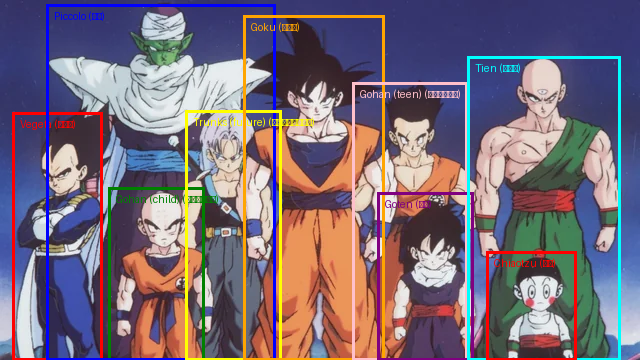

In [7]:
# Example: Anime character recognition
image_path = "../assets/whats-a-dragon-ball-opinion-you-hold-that-gets-everyone-v0-a7tpukavv59c1.webp"
prompt = "Identify the anime characters in the image. Return their bounding boxes and names in the objects array."

image = Image.open(image_path)
image.thumbnail([640, 640], Image.Resampling.LANCZOS)

result = inference_with_json_schema(image_path, prompt, RecognitionList)
print(json.dumps(result, indent=2))

plot_recognition_results(image, result["objects"])